## Fetal lung on pan-fetal immune

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import glob
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy
import anndata

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

import milopy
import milopy.core as milo

In [3]:
# from oor_benchmark.metrics import auprc, FDR_TPR_FPR

In [4]:
## r2py setup
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(tidyverse)

System has not been booted with systemd as init system (PID 1). Can't operate.
Failed to create bus connection: Host is down


In [7]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');
    
def make_ct_label(label):
    return(' '.join(label.split('_')))

In [8]:
sns.color_palette('Paired')

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

In [9]:
## Define color palette
pal = sns.color_palette('Paired').as_hex()
design_palette = {'ACR':pal[3], 'CR':pal[7], 'AR':pal[9], 'joint_CR':pal[6]}
design_palette_df = pd.DataFrame(design_palette.values(), index =design_palette.keys() )
design_palette_df.columns = ['color']

In [10]:
# figdir = '/home/jovyan/mount/gdrive/diff2atlas/figures/pbmc_design_comparison_Embedding_methods/'
# if not os.path.exists(figdir):
#     os.mkdir(figdir)

In [11]:
# %%R -i design_palette_df -i figdir
# design_palette = setNames(design_palette_df$color, rownames(design_palette_df))

## Prep atlas dataset 

Downloaded from [here](https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad)

In [12]:
## Subsample by sample
np.random.seed(2345)

def _subsample(adata, sample_col, n_cells_sample = 1000):
    s_obs = pd.Series() 
    for s in adata.obs[sample_col].unique():
        s_obs_i = adata.obs_names[adata.obs[sample_col] == s]
        if s_obs_i.shape[0] > n_cells_sample:
            obs_df = adata.obs.loc[s_obs_i]
            obs_df[sample_col] = obs_df[sample_col].astype('str')
            s_obs_i = obs_df[[sample_col]].groupby(
                sample_col).sample(n_cells_sample).index
        s_obs = pd.concat([s_obs, pd.Series(s_obs_i)])
    s_obs = s_obs.values
    return(s_obs)

In [13]:
h5ad_file = '/nfs/team205/ed6/data/Fetal_immune/cellxgene_h5ad_files/scRNA_data/PAN.A01.v01.raw_count.20210429.PFI.embedding.h5ad'
adata_atlas = sc.read_h5ad(h5ad_file, backed=True)

In [14]:
## Remove low Q
lowQ_clusters = [
    "DOUBLET_IMMUNE_FIBROBLAST",
    "LOW_Q_INCONSISTENT",
    "DOUBLET_LYMPHOID_MACROPHAGE",
    "LOW_QUALITY",
    "HIGH_MITO",
    "DOUBLETS_FIBRO_ERY",
    "DOUBLET_ENDOTHELIUM_ERYTHROCYTE",
    "DOUBLET_ERY_B",
    "LOW_QUALITY_MACROPHAGE",
    "LOW_QUALITY_MID_ERY_(HIGH_RIBO)",
    "PLACENTAL_CONTAMINANTS",
    "DOUBLET",
    ]

keep_obs = adata_atlas.obs_names[
    (~adata_atlas.obs['organ'].isna()) & # remove maternal contaminants
    (~adata_atlas.obs['celltype_annotation'].isin(lowQ_clusters)) &  # remove low quality
    (adata_atlas.obs['age'] >= 14) # Filter by age
] 

keep_obs = _subsample(adata_atlas[keep_obs], sample_col='Sample', n_cells_sample=2000)

/tmp/ipykernel_15629/2809032511.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s_obs = pd.Series()


In [15]:
len(keep_obs)

191830

In [16]:
adata_atlas = adata_atlas[keep_obs].to_memory()

In [17]:
print('--- Atlas ---')
print('# donors:', adata_atlas.obs['donor'].nunique())
print('# samples:', adata_atlas.obs['Sample'].nunique())

--- Atlas ---
# donors: 11
# samples: 99


## Prep case-control dataset

Downloaded from [cellxgene](https://cellxgene.cziscience.com/collections/2d2e2acd-dade-489f-a2da-6c11aa654028)

In [18]:
h5ad_file = '/nfs/team205/ed6/data/He2020_fetal_lung.h5ad'
adata_query = sc.read_h5ad(h5ad_file, backed=True)

In [19]:
query_ages = ['18th week post-fertilization human stage', 
 '22nd week post-fertilization human stage', 
 '15th week post-fertilization human stage', 
 '20th week post-fertilization human stage', 
 ]

keep_obs = adata_query.obs_names[
    adata_query.obs['development_stage'].isin(query_ages)
]

keep_obs = _subsample(adata_query[keep_obs], sample_col='batch', n_cells_sample=1000)

/tmp/ipykernel_15629/2809032511.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s_obs = pd.Series()


In [20]:
adata_query = adata_query[keep_obs].to_memory()

In [21]:
print('--- Query ---')
print('# donors:', adata_query.obs['donor_id'].nunique())
print('# samples:', adata_query.obs['batch'].nunique())

--- Query ---
# donors: 8
# samples: 22


Uniform metadata

In [23]:
adata_query.obs['method'] = '5GEX'
adata_query.obs['Sample'] = adata_query.obs['batch'].copy()
adata_query.obs['donor'] = adata_query.obs['donor_id'].copy()

In [31]:
## Set ensemblIDs to var names
adata_atlas.var_names = adata_atlas.var['GeneID'].values

In [37]:
## Keep common vars
adata_query = adata_query[:, np.intersect1d(adata_query.var_names, adata_atlas.var_names)].copy()
adata_atlas = adata_atlas[:, np.intersect1d(adata_query.var_names, adata_atlas.var_names)].copy()

### Save for simulations

In [38]:
adata_atlas.write_h5ad('/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_fetal/PFI_atlas.subsampled.h5ad')
adata_query.write_h5ad('/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_fetal/FL_query.subsampled.h5ad')

### Select cell types for OOR simulation

In [41]:
adata_query.obs['sample_id'] = adata_query.obs['donor'].astype("str") + "_" + adata_query.obs['method'].astype('str')

In [51]:
adata_query.obs.columns

Index(['batch', 'dissection', 'chemistry', 'percent_mito', 'n_counts',
       'n_genes', 'doublet_scores', 'bh_pval', 'leiden', 'phase', 'S_score',
       'G2M_score', 'new_celltype', 'big_cluster', 'broad_celltype',
       'assay_ontology_term_id', 'cell_type_ontology_term_id',
       'development_stage_ontology_term_id', 'disease_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'is_primary_data',
       'organism_ontology_term_id', 'sex_ontology_term_id',
       'tissue_ontology_term_id', 'donor_id', 'suspension_type', 'cell_type',
       'assay', 'disease', 'organism', 'sex', 'tissue',
       'self_reported_ethnicity', 'development_stage', 'method', 'Sample',
       'donor', 'sample_id'],
      dtype='object')

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


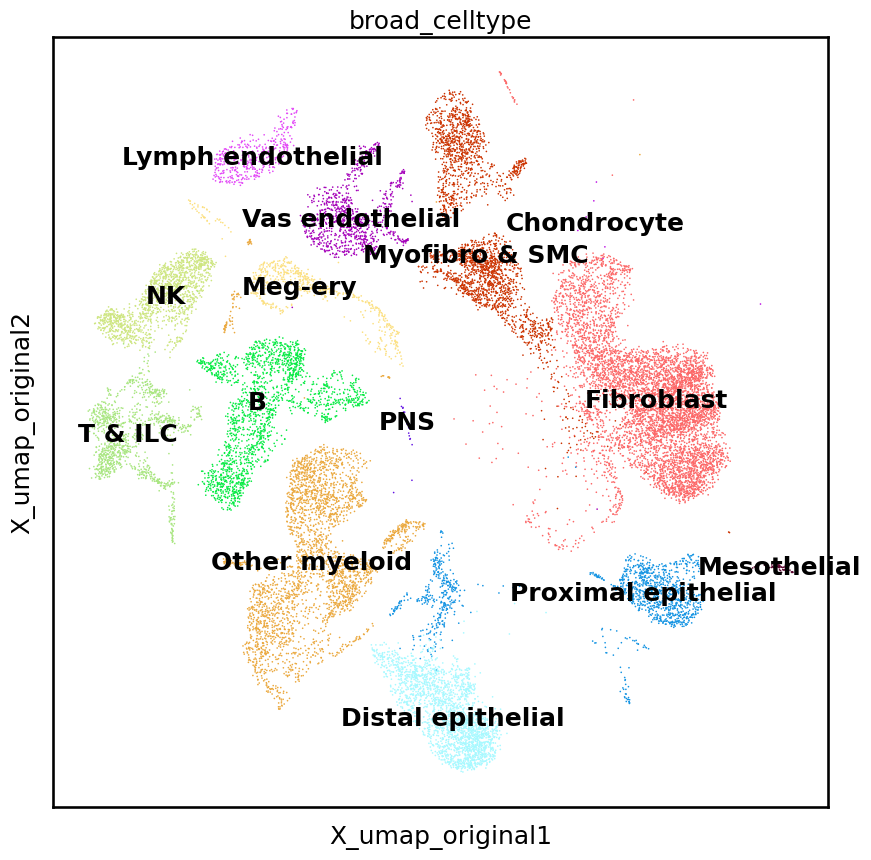

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


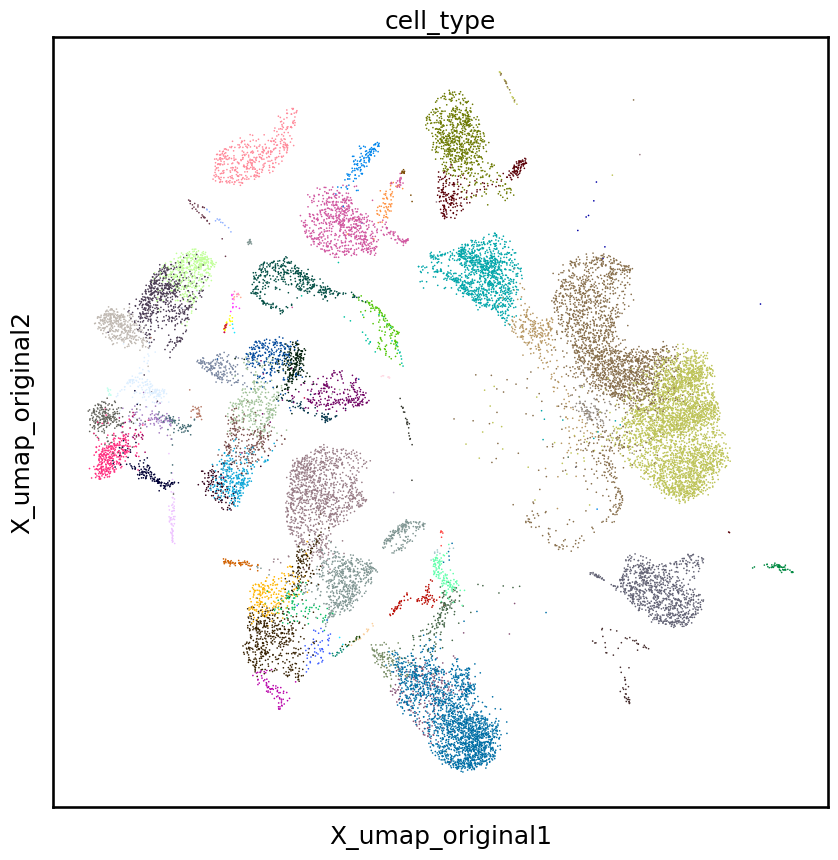

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


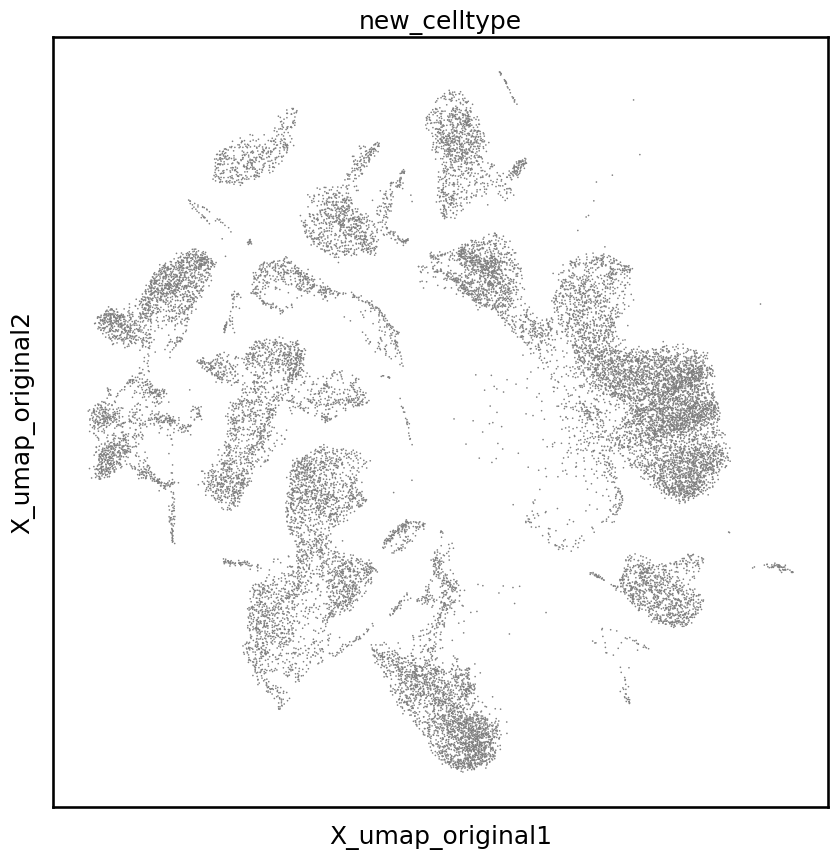

In [84]:
with plt.rc_context({'figure.figsize':[10,10]}):
    sc.pl.embedding(adata_query, 'X_umap_original', color='broad_celltype', legend_loc='on data')
    sc.pl.embedding(adata_query, 'X_umap_original', color='cell_type', legend_loc='none')
    sc.pl.embedding(adata_query, 'X_umap_original', color='new_celltype', legend_loc='none')

In [65]:
df = adata_query.obs.groupby(['broad_celltype', 'cell_type']).size().reset_index()
df = df[df[0] > 0]

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


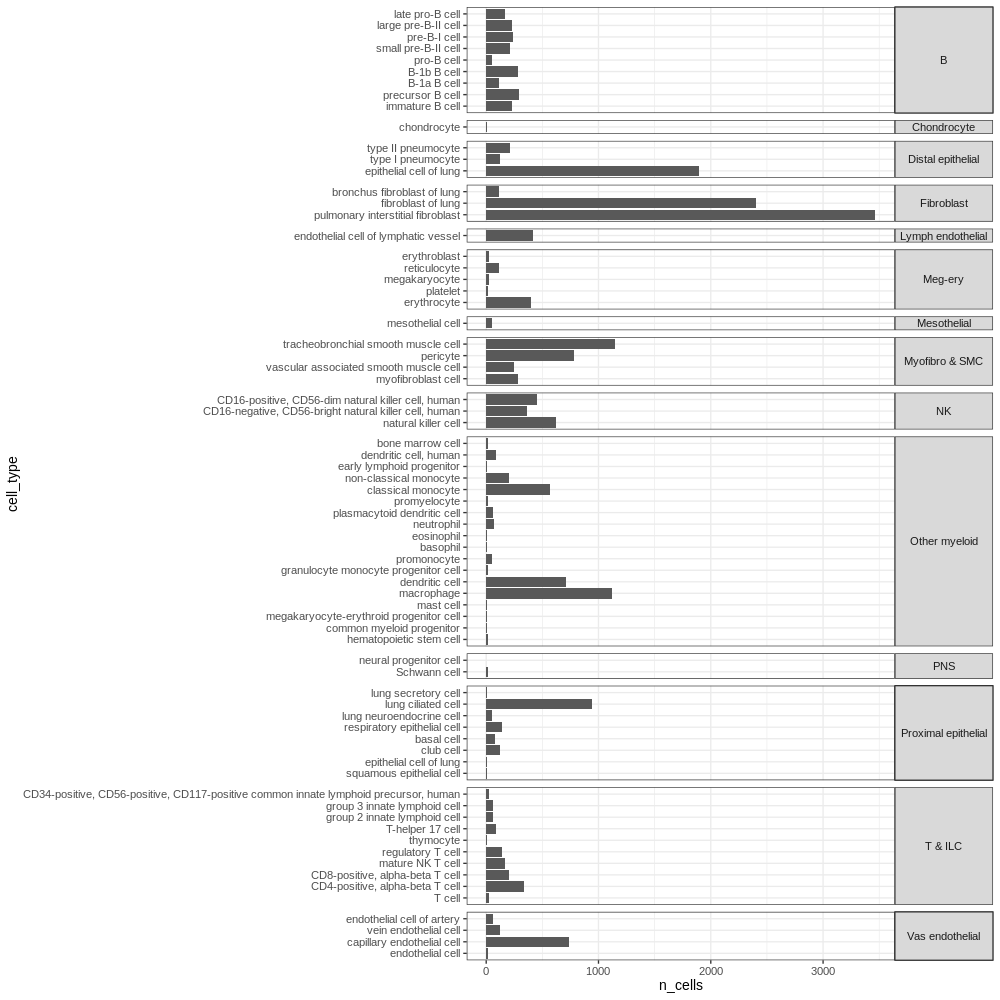

In [75]:
%%R -i df -h 1000 -w 1000
df %>%
mutate(n_cells = `0`) %>%
ggplot(aes(cell_type, n_cells)) +
geom_col() +
coord_flip() +
theme_bw(base_size=14) +
facet_grid(broad_celltype~., space='free', scales='free') +
theme(strip.text.y=element_text(angle=0))

In [87]:
df[df[0] > 300].sort_values(0)

,broad_celltype,cell_type,0
874,T & ILC,"CD4-positive, alpha-beta T cell",338
612,NK,"CD16-negative, CD56-bright natural killer cell...",366
367,Meg-ery,erythrocyte,398
341,Lymph endothelial,endothelial cell of lymphatic vessel,418
613,NK,"CD16-positive, CD56-dim natural killer cell, h...",452
678,Other myeloid,classical monocyte,568
589,NK,natural killer cell,622
655,Other myeloid,dendritic cell,707
981,Vas endothelial,capillary endothelial cell,737
522,Myofibro & SMC,pericyte,786


In [94]:
adata_query.obs['cell_type_clean'] = adata_query.obs['cell_type'].str.replace(" ", '_').str.replace("-", '_').str.replace(",", '')

immune_cts = ['natural_killer_cell', 'classical_monocyte', 'dendritic_cell']
stromal_cts = ['fibroblast_of_lung', 'pericyte', 'lung_ciliated_cell']

In [98]:
adata_query.obs['cell_type_clean'][adata_query.obs['cell_type_clean'].isin(immune_cts)].value_counts()

dendritic_cell         707
natural_killer_cell    622
classical_monocyte     568
Name: cell_type_clean, dtype: int64

In [99]:
adata_query.obs['cell_type_clean'][adata_query.obs['cell_type_clean'].isin(stromal_cts)].value_counts()

fibroblast_of_lung    2400
lung_ciliated_cell     941
pericyte               786
Name: cell_type_clean, dtype: int64

### Save datasets with OOR simulation

In [142]:
from oor_benchmark.datasets.simulation import simulate_query_reference
from oor_benchmark.api import check_dataset

In [143]:
split_seed = 2020
np.random.seed(split_seed)
all_samples = adata_query.obs['sample_id'].unique()
query_samples = np.random.choice(all_samples, size=int(len(all_samples)/2), replace=False)
ctrl_samples = all_samples[~all_samples.isin(query_samples)]

In [144]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_fetal/'

In [ ]:
adata_query = adata_query.raw.to_adata()

In [148]:
outdir

'/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_fetal/'

In [147]:
annotation_col = 'cell_type_clean'

for ct in immune_cts + stromal_cts:
    print(ct)
    adata = simulate_query_reference(
        adata_query, query_annotation=[ct],
        annotation_col=annotation_col, 
        batch_col='sample_id',
        query_batch = query_samples.tolist(),
        ctrl_batch = ctrl_samples.tolist(),
    )

    # Save intermediate files
    sim_id = f"He2022_lung_{annotation_col}{ct}_seed{split_seed}/"
    if not os.path.exists(outdir + sim_id):
        os.mkdir(outdir + sim_id)

    # Run embedding and differential abundance testing
    if 'X_scVI' in adata.obsm:
        del adata.obsm['X_scVI']
        
    assert check_dataset(adata)
    adata.write_h5ad(outdir + sim_id + 'query_ctrl_adata.h5ad')

natural_killer_cell
classical_monocyte
dendritic_cell
fibroblast_of_lung
pericyte
lung_ciliated_cell


## Run design comparison

### Parse results

In [129]:
outdir = '/lustre/scratch117/cellgen/team205/ed6/OOR_benchmark_fetal/'

In [130]:
from oor_benchmark.metrics import FDR_TPR_FPR
from oor_benchmark.metrics import auprc
from oor_benchmark.methods.scArches_milo import run_milo

def harmonize_output(adata, signif_alpha=0.1):
#     if adata.isbacked:
#         sample_adata = adata.uns['nhood_adata'].to_memory().T
#     else:
    sample_adata = adata.uns["nhood_adata"].T.copy()
    sample_adata.var["OOR_score"] = sample_adata.var["logFC"].copy()
    sample_adata.var["OOR_signif"] = (
        ((sample_adata.var["SpatialFDR"] < signif_alpha) &
         (sample_adata.var["logFC"] > 0)).astype(int).copy()
    )
    sample_adata.varm["groups"] = adata.obsm["nhoods"].T
    adata.uns["sample_adata"] = sample_adata.copy()

def read_oor_design_output(simdir, ref_design, population_obs):
    perturb_pop = simdir.split(population_obs)[1].split('_seed')[0]
    print(f'Reading {perturb_pop}\n')
    h5ad_file = simdir + f'/{ref_design}_design.h5ad'
    adata = milopy.utils.read_milo_adata(
                h5ad_file, backed=False)
    adata.obs['OOR_state_name'] = perturb_pop
    return(adata)

def parse_design(adata, ref_design):
    if 'sample_adata' not in adata.uns:
        harmonize_output(adata)
    perturb_pop = adata.obs['OOR_state_name'].unique()[0]
    tpr_df = FDR_TPR_FPR.FDR_TPR_FPR(adata)
    auprc_df = auprc.auprc(adata, return_curve=True)
    nhoods_df = adata.uns['sample_adata'].var.copy()
    tpr_df['design'] = ref_design
    tpr_df['OOR_state_name'] = perturb_pop
    auprc_df['design'] = ref_design
    auprc_df['OOR_state_name'] = perturb_pop
    nhoods_df['design'] = ref_design
    nhoods_df['OOR_state_name'] = perturb_pop
    return(nhoods_df, tpr_df, auprc_df)

In [131]:
for d in [x for x in os.listdir(outdir) if x.startswith("He2022")]:
    simdir = outdir + d
    nhoods_df_all = pd.DataFrame()
    tpr_df_all = pd.DataFrame()
    auprc_df_all = pd.DataFrame()

    for d in ['ACR', "CR"]:
        adata = read_oor_design_output(simdir, d, population_obs='cell_type_clean')
#         run_milo(adata, "query", 'ctrl', sample_col='batch', annotation_col='cell_type_clean', design='~chemistry+is_query')
        if adata is not None:
            nhoods_df, tpr_df, auprc_df = parse_design(adata, d)
            nhoods_df_all = pd.concat([nhoods_df_all, nhoods_df])
            tpr_df_all = pd.concat([tpr_df_all, tpr_df])
            auprc_df_all = pd.concat([auprc_df_all, auprc_df])

    # print(auprc_df_all.head())
    nhoods_df_all.to_csv(simdir + f'/nhoods_obs.csv')
    tpr_df_all.to_csv(simdir + f'/TPR_res.csv')
    auprc_df_all.to_csv(simdir + f'/AUPRC_res.csv')

Reading lung_ciliated_cell

Reading lung_ciliated_cell

Reading natural_killer_cell

Reading natural_killer_cell

Reading classical_monocyte

Reading classical_monocyte

Reading fibroblast_of_lung

Reading fibroblast_of_lung

Reading pericyte

Reading pericyte

Reading dendritic_cell

Reading dendritic_cell



### Read results

In [82]:
nhoods_df_all = pd.DataFrame()
auprc_df_all = pd.DataFrame()
tpr_df_all = pd.DataFrame()
for d in [x for x in os.listdir(outdir) if x.startswith("He2022")]:
    simdir = outdir + d 
    nh_df = pd.read_csv(f'{simdir}/nhoods_obs.csv', index_col=0)
    tpr_df = pd.read_csv(f'{simdir}/TPR_res.csv', index_col=0)
    auprc_df = pd.read_csv(f'{simdir}/AUPRC_res.csv', index_col=0)
    auprc_df_all = pd.concat([auprc_df_all, auprc_df])
    nhoods_df_all = pd.concat([nhoods_df_all, nh_df])
    tpr_df_all = pd.concat([tpr_df_all, tpr_df])

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


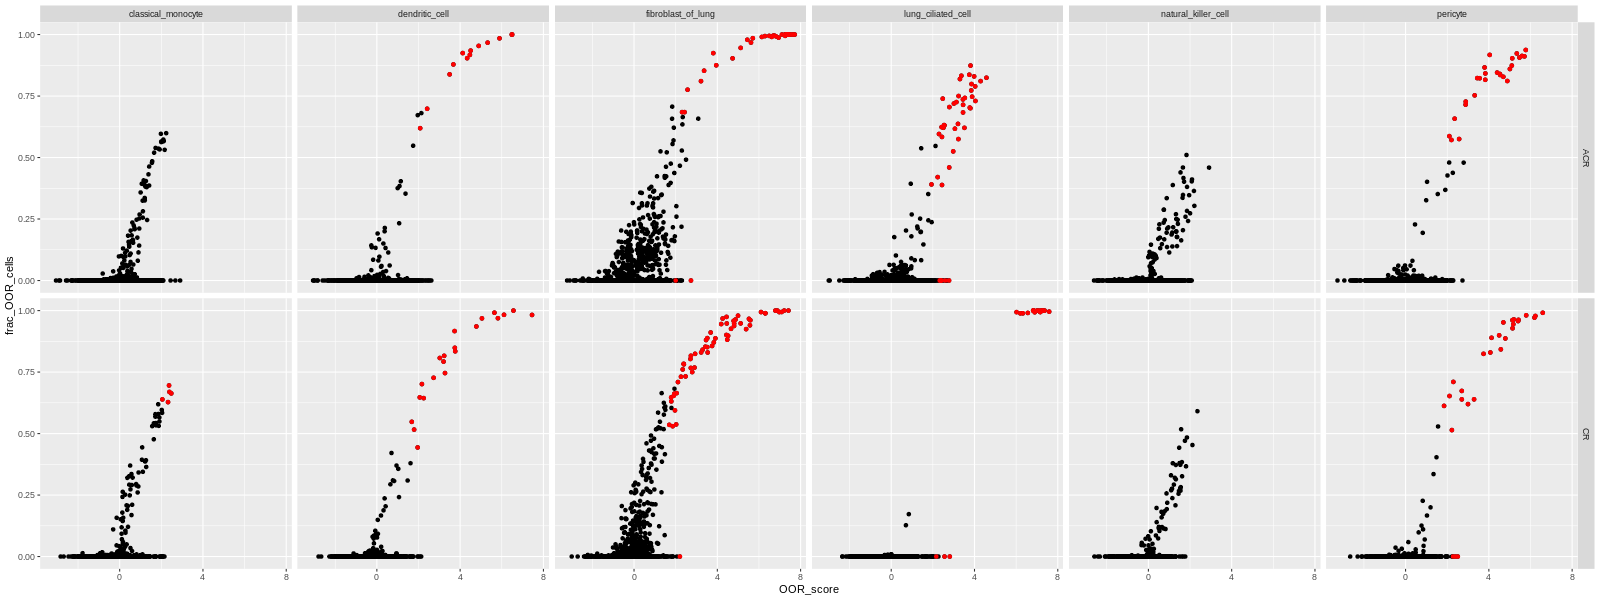

In [90]:
%%R -i nhoods_df_all -w 1600 -h 600
nhoods_df_all %>%
    mutate(signif=ifelse(SpatialFDR < 0.1 & logFC > 0, 'signif', NA)) %>%
    ggplot(aes(OOR_score, frac_OOR_cells)) +
    geom_point() +
    geom_point(data=. %>% filter(!is.na(signif)), color='red') +
    facet_grid(design~OOR_state_name)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


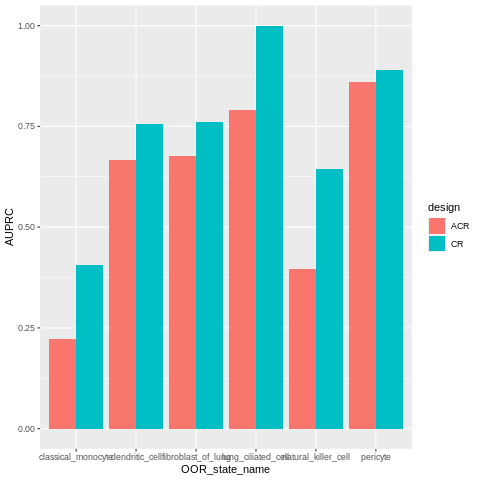

In [84]:
%%R -i auprc_df_all
auprc_df_all %>%
ggplot(aes(OOR_state_name, AUPRC, fill=design)) +
       geom_col(position='dodge')

In [85]:
tpr_df_all

,TP,FP,FN,TN,TPR,FPR,FDR,design,OOR_state_name
0,38,6,15,1397,0.716981,0.004277,0.136364,ACR,lung_ciliated_cell
0,17,3,0,1367,1.000000,0.002190,0.150000,CR,lung_ciliated_cell
0,0,0,57,1447,0.000000,0.000000,0.000000,ACR,natural_killer_cell
0,0,0,38,1433,0.000000,0.000000,0.000000,CR,natural_killer_cell
0,0,0,52,1420,0.000000,0.000000,0.000000,ACR,classical_monocyte
0,5,0,48,1363,0.094340,0.000000,0.000000,CR,classical_monocyte
0,36,2,78,1291,0.315789,0.001547,0.052632,ACR,fibroblast_of_lung
0,59,1,76,1265,0.437037,0.000790,0.016667,CR,fibroblast_of_lung
0,26,0,10,1437,0.722222,0.000000,0.000000,ACR,pericyte
0,25,3,5,1438,0.833333,0.002082,0.107143,CR,pericyte


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():


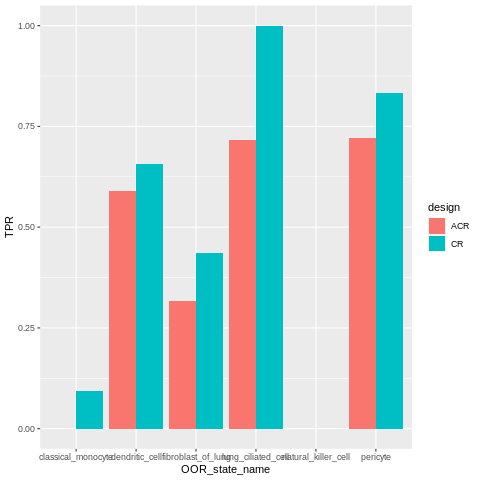

In [88]:
%%R -i tpr_df_all
tpr_df_all %>%

    ggplot(aes(OOR_state_name, TPR, fill=design)) +
    geom_col(position='dodge')

---

In [14]:
[x for x in os.listdir(outdir) if x.startswith("He2022")]

['He2022_lung_cell_type_cleanlung_ciliated_cell_seed2020',
 'He2022_lung_cell_type_cleannatural_killer_cell_seed2020',
 'He2022_lung_cell_type_cleanclassical_monocyte_seed2020',
 'He2022_lung_cell_type_cleanfibroblast_of_lung_seed2020',
 'He2022_lung_cell_type_cleanpericyte_seed2020',
 'He2022_lung_cell_type_cleandendritic_cell_seed2020']

In [68]:
simdir = outdir + 'He2022_lung_cell_type_cleannatural_killer_cell_seed2020'
adata_cr = read_oor_design_output(simdir, 'CR', population_obs='cell_type_clean')
adata_acr = read_oor_design_output(simdir, 'ACR', population_obs='cell_type_clean')
sc.tl.umap(adata_cr)
sc.tl.umap(adata_acr)

Reading natural_killer_cell

Reading natural_killer_cell



/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


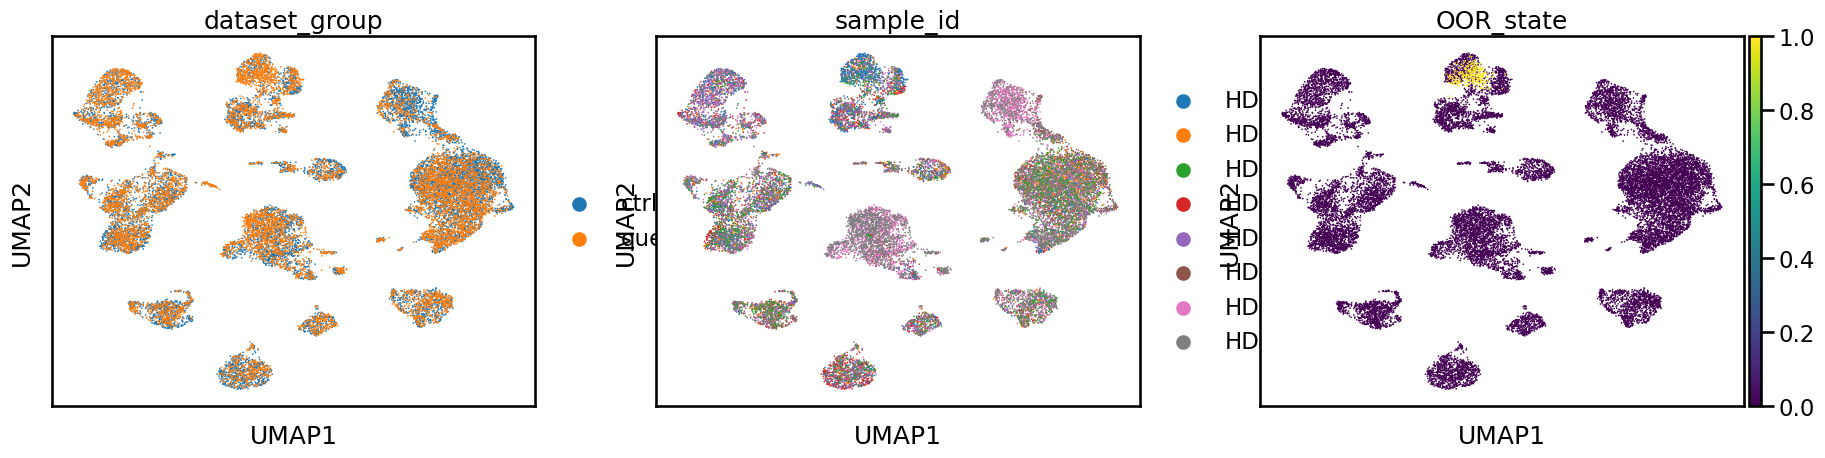

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


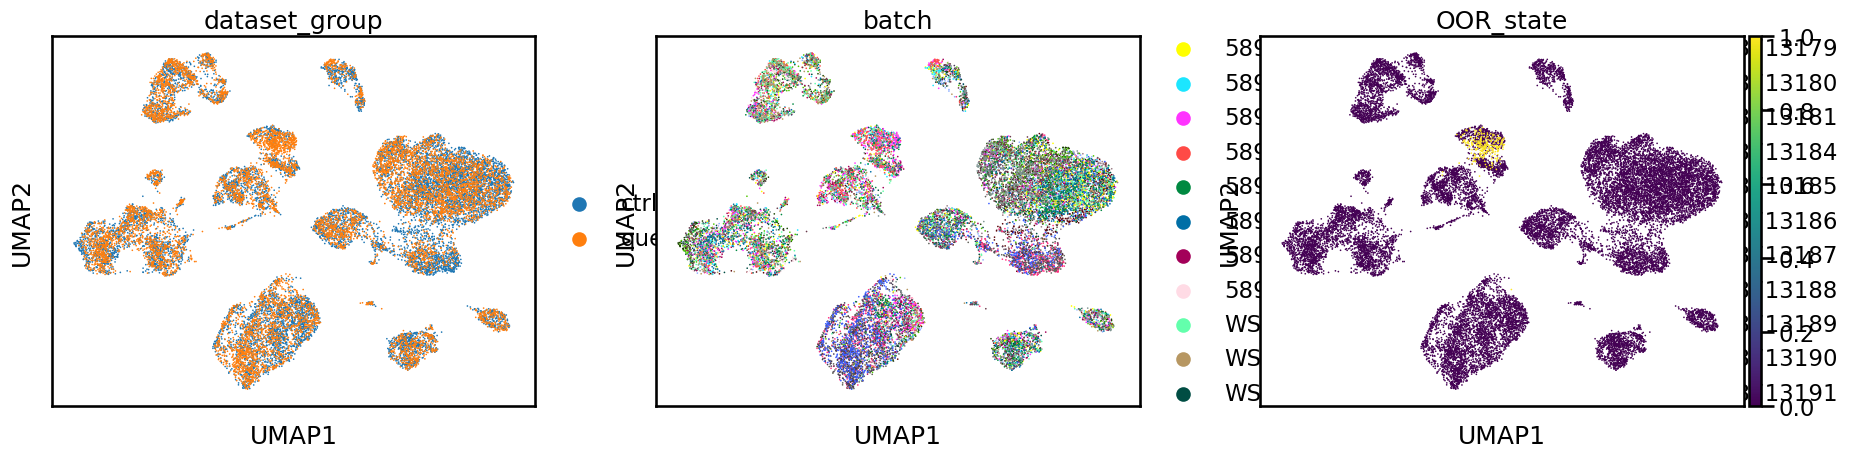

In [16]:
sc.pl.umap(adata_cr, color=['dataset_group','sample_id','OOR_state'])
sc.pl.umap(adata_acr, color=['dataset_group','batch','OOR_state'])

In [120]:
def hvg_batch(
    adata,
    batch_key=None,
    target_genes=2000,
    flavor="cell_ranger",
    n_bins=20,
    adataOut=False,
):
    """Batch-aware highly variable gene selection
    Method to select HVGs based on mean dispersions of genes that are highly
    variable genes in all batches. Using a the top target_genes per batch by
    average normalize dispersion. If target genes still hasn't been reached,
    then HVGs in all but one batches are used to fill up. This is continued
    until HVGs in a single batch are considered.
    :param adata: ``anndata`` object
    :param batch: ``adata.obs`` column
    :param target_genes: maximum number of genes (intersection reduces the number of genes)
    :param flavor: parameter for ``scanpy.pp.highly_variable_genes``
    :param n_bins: parameter for ``scanpy.pp.highly_variable_genes``
    :param adataOut: whether to return an ``anndata`` object or a list of highly variable genes
    """

#     if batch_key is not None:
#         utils.check_batch(batch_key, adata.obs)

    adata_hvg = adata if adataOut else adata.copy()

    n_batches = len(adata_hvg.obs[batch_key].cat.categories)

    # Calculate double target genes per dataset
    sc.pp.highly_variable_genes(
        adata_hvg,
        flavor=flavor,
        n_top_genes=target_genes,
        n_bins=n_bins,
        batch_key=batch_key,
    )

    nbatch1_dispersions = adata_hvg.var["dispersions_norm"][
        adata_hvg.var.highly_variable_nbatches
        > len(adata_hvg.obs[batch_key].cat.categories) - 1
    ]

    nbatch1_dispersions.sort_values(ascending=False, inplace=True)

    if len(nbatch1_dispersions) > target_genes:
        hvg = nbatch1_dispersions.index[:target_genes]

    else:
        enough = False
        print(f"Using {len(nbatch1_dispersions)} HVGs from full intersect set")
        hvg = nbatch1_dispersions.index[:]
        not_n_batches = 1

        while not enough:
            target_genes_diff = target_genes - len(hvg)

            tmp_dispersions = adata_hvg.var["dispersions_norm"][
                adata_hvg.var.highly_variable_nbatches == (n_batches - not_n_batches)
            ]

            if len(tmp_dispersions) < target_genes_diff:
                print(
                    f"Using {len(tmp_dispersions)} HVGs from n_batch-{not_n_batches} set"
                )
                hvg = hvg.append(tmp_dispersions.index)
                not_n_batches += 1

            else:
                print(
                    f"Using {target_genes_diff} HVGs from n_batch-{not_n_batches} set"
                )
                tmp_dispersions.sort_values(ascending=False, inplace=True)
                hvg = hvg.append(tmp_dispersions.index[:target_genes_diff])
                enough = True

    print(f"Using {len(hvg)} HVGs")

    if not adataOut:
        del adata_hvg
        return hvg.tolist()
    else:
        return adata_hvg[:, hvg].copy()

In [97]:
sc.pp.normalize_total(adata_acr)
sc.pp.log1p(adata_acr)

Layers with keys: counts

In [121]:
a = hvg_batch(adata_acr, target_genes=5000, batch_key='batch')

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/prepr

Using 960 HVGs from full intersect set
Using 388 HVGs from n_batch-1 set
Using 398 HVGs from n_batch-2 set
Using 324 HVGs from n_batch-3 set
Using 307 HVGs from n_batch-4 set
Using 309 HVGs from n_batch-5 set
Using 299 HVGs from n_batch-6 set
Using 267 HVGs from n_batch-7 set
Using 290 HVGs from n_batch-8 set
Using 258 HVGs from n_batch-9 set
Using 284 HVGs from n_batch-10 set
Using 315 HVGs from n_batch-11 set
Using 325 HVGs from n_batch-12 set
Using 276 HVGs from n_batch-13 set
Using 5000 HVGs


/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)


In [123]:
vars_model = sc.read(outdir + d + '/model_ctrlquery/adata.h5ad', backed=True).var

In [128]:
np.intersect1d(vars_model.index, a).shape

(2916,)

In [102]:

# adata_acr.uns['nhood_adata'] = adata_acr.uns['nhood_adata'].to_memory()

In [75]:
import milopy
import oor_benchmark.methods
oor_benchmark.methods.scArches_milo.run_milo(adata_acr, "query", 'ctrl', sample_col='batch', annotation_col='cell_type_clean', design='~chemistry+is_query')
milopy.utils.build_nhood_graph(adata_acr)

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


In [ ]:
milopy.plot.plot_nhood_graph(adata_acr, alpha=0.1, min_size=1)

In [73]:
adata_acr.obs[['batch', 'chemistry', 'sample_id', 'dataset_group']].drop_duplicates()

,batch,chemistry,sample_id,dataset_group
CCTAGCTAGGCCCTTG-5891STDY8062349,5891STDY8062349,Normal,HDBR14808_5GEX,ctrl
TACTCGCAGTCGAGTG-WSSS_F_LNG8713180,WSSS_F_LNG8713180,Trypsin+,HDBR15168_5GEX,ctrl
TCGAGGCTCAGTACGT-WSSS_F_LNG8713181,WSSS_F_LNG8713181,Trypsin+,HDBR15168_5GEX,ctrl
AGAGCTTTCCAAAGTC-WSSS_F_LNG8713178,WSSS_F_LNG8713178,Normal,HDBR15168_5GEX,ctrl
TAGACCATCGTACCGG-WSSS_F_LNG8713179,WSSS_F_LNG8713179,Normal,HDBR15168_5GEX,ctrl
ACTTTCATCTGGTATG-WSSS_F_LNG8713191,WSSS_F_LNG8713191,Trypsin+CD326,HDBR15219_5GEX,ctrl
GCAGTTAGTACCTACA-WSSS_F_LNG8713190,WSSS_F_LNG8713190,Trypsin+CD326,HDBR15219_5GEX,ctrl
CCTTACGGTCACAAGG-WSSS_F_LNG8713186,WSSS_F_LNG8713186,Normal,HDBR15219_5GEX,ctrl
CGGCTAGCAGTAGAGC-WSSS_F_LNG8713187,WSSS_F_LNG8713187,Normal,HDBR15219_5GEX,ctrl
GCTGGGTGTTAAGATG-5891STDY8062356,5891STDY8062356,Normal,HDBR14854_5GEX,ctrl


In [66]:
adata_acr.obs[['batch', 'sample_id']].drop_duplicates().value_counts('sample_id')

sample_id
HDBR15168_5GEX    4
HDBR15219_5GEX    4
HDBR15233_5GEX    4
HDBR14804_5GEX    2
HDBR14808_5GEX    2
HDBR14853_5GEX    2
HDBR14854_5GEX    2
HDBR15167_5GEX    2
dtype: int64

In [38]:
import milopy
# sc.pp.neighbors(adata_cr, use_rep='X_scVI', n_neighbors=100)



/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/rpy2/robjects/pandas2ri.py:56: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


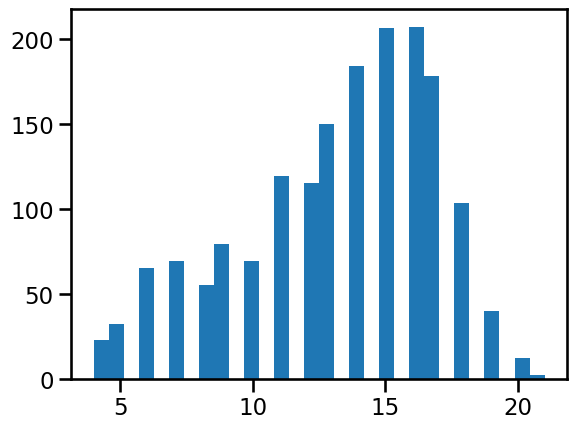

In [60]:
nonz = adata_acr.uns['nhood_adata'].X.copy()
nonz[nonz.nonzero()] = 1
plt.hist(np.array(nonz.sum(1)).flatten(), bins=30);

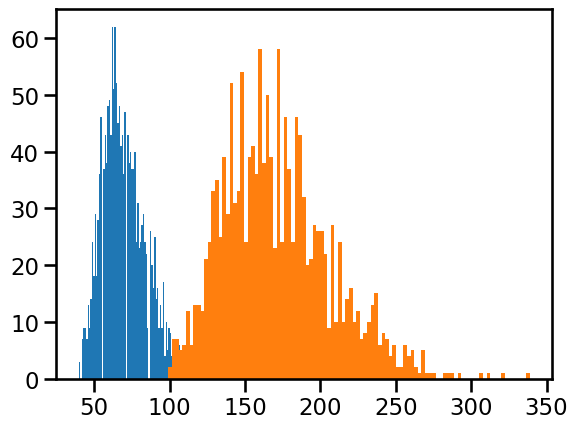

In [54]:
plt.hist(np.array(adata_acr.obsm['nhoods'].sum(0)).flatten(), bins=100);
plt.hist(np.array(adata_cr.obsm['nhoods'].sum(0)).flatten(), bins=100);

/home/jovyan/my-conda-envs/oor-benchmark/lib/python3.10/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


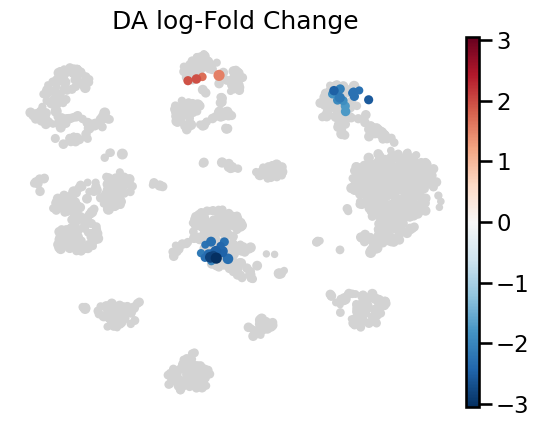

In [52]:
milopy.utils.build_nhood_graph(adata_cr)
milopy.plot.plot_nhood_graph(adata_cr, alpha=0.5, min_size=1)

In [40]:
import matplotlib

def plot_milo_diagnostics(nhood_adata, alpha = 0.1, figsize=[12, 12]):
    with matplotlib.rc_context({"figure.figsize": figsize}):

        ## Check P-value histogram
        plt.subplot(2, 2, 1)
        plt.hist(nhood_adata.obs["PValue"], bins=20)
        plt.xlabel("Uncorrected P-value")

        ## Visualize extent of multiple-testing correction
        plt.subplot(2, 2, 2)
        plt.scatter(nhood_adata.obs["PValue"], nhood_adata.obs["SpatialFDR"], s=3)
        plt.xlabel("Uncorrected P-value")
        plt.ylabel("SpatialFDR")

        ## Visualize volcano plot
        plt.subplot(2, 2, 3)
        plt.scatter(
            nhood_adata.obs["logFC"], -np.log10(nhood_adata.obs["SpatialFDR"]), s=3
        )
        plt.axhline(
            y=-np.log10(alpha),
            color="red",
            linewidth=1,
            label=f"{int(alpha*100)} % SpatialFDR",
        )
        plt.legend()
        plt.xlabel("log-Fold Change")
        plt.ylabel("- log10(SpatialFDR)")
        plt.tight_layout()

        ## Visualize MA plot
        df = nhood_adata.obs
        emp_null = df[df["SpatialFDR"] >= alpha]["logFC"].mean()
        df["Sig"] = df["SpatialFDR"] < alpha

        plt.subplot(2, 2, 4)
        sns.scatterplot(data=df, x="logCPM", y="logFC", hue="Sig")
        plt.axhline(y=0, color="grey", linewidth=1)
        plt.axhline(y=emp_null, color="purple", linewidth=1)
        plt.legend(title=f"< {int(alpha*100)} % SpatialFDR")
        plt.xlabel("Mean log-counts")
        plt.ylabel("log-Fold Change")
        plt.show()

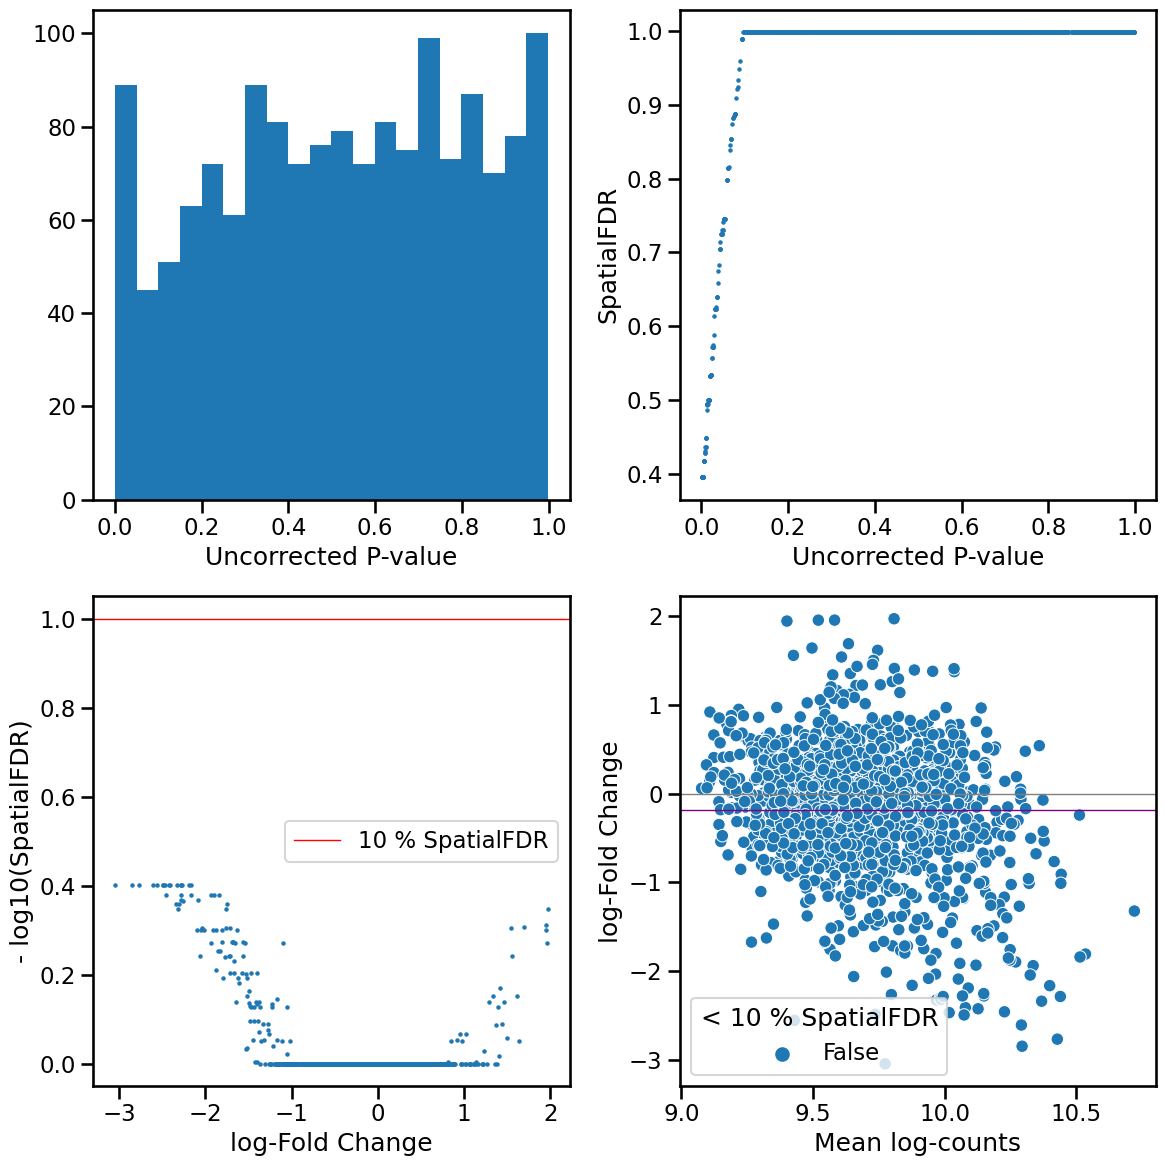

In [42]:
plot_milo_diagnostics(adata_cr.uns['nhood_adata'])

In [37]:
adata_cr.uns['neighbors']

OverloadedDict, wrapping:
	{'connectivities_key': 'connectivities', 'distances_key': 'distances', 'params': {'method': 'umap', 'metric': 'euclidean', 'n_neighbors': 40, 'random_state': 0, 'use_rep': 'X_scVI'}}
With overloaded keys:
	['connectivities', 'distances'].

In [89]:
harmonize_output(adata_cr)

In [90]:
FDR_TPR_FPR.FDR_TPR_FPR(adata_cr)

,TP,FP,FN,TN,TPR,FPR,FDR
0,24,1,8,1616,0.75,0.000618,0.04


In [91]:
tpr_df_all

""
